Plot the score box plot and histogram plot

In [1]:
import sys
sys.path.append("/home/wanxinli/EHR-OT/")

from ast import literal_eval
from common import *
from math import floor
from mimic_common import *
from multiprocess import Pool
import numpy as np
import os
import pandas as pd
import random
import scipy.stats as ss
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
import scipy.stats as ss
from statistics import median
import time


/home/wanxinli/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
output_dir = os.path.join(os.path.expanduser("~"), f"EHR-OT/outputs/mimic")
print(f"Will save outputs to {output_dir}")
label_code_path = os.path.join(output_dir, "selected_summary_mimic.csv")


Will save outputs to /home/wanxinli/EHR-OT/outputs/mimic


In [3]:
label_code_path = os.path.join(output_dir, "selected_summary_mimic.csv")
label_code_df = pd.read_csv(label_code_path, header=0, index_col=0)
label_codes = list(label_code_df.index)

trans_codes = []
untrans_codes = []
undec_codes = []
for label_code in label_codes:
    score_path = os.path.join(output_dir, f"exp3_{label_code}_score.csv")
    if os.path.exists(score_path):
        df = pd.read_csv(score_path, header=0, index_col=0)
        label_code_df.at[label_code, 'div_score'] = median(list(df['transfer_score']))

label_code_df.to_csv(os.path.join(output_dir, "selected_summary_mimic.csv"), header=True, index=True)


In [4]:
label_code_df = pd.read_csv(label_code_path, header=0, index_col=0)
label_code_df

,short title,long title,male rate,female rate,male to female rate ratio,male freq,female freq,div_score
ICD code,,,,,,,,
008.45,Int inf clstrdium dfcile,Intestinal infection due to Clostridium difficile,0.022094,0.027511,0.803101,728.0,716.0,113.460863
041.11,Mth sus Stph aur els/NOS,Methicillin susceptible Staphylococcus aureus ...,0.012504,0.011181,1.118295,412.0,291.0,149.294600
042,Human immuno virus dis,Human immunodeficiency virus [HIV] disease,0.012322,0.005072,2.429428,406.0,132.0,165.461945
038.11,Meth susc Staph aur sept,Methicillin susceptible Staphylococcus aureus ...,0.010137,0.006955,1.457538,334.0,181.0,120.518726
038.9,Septicemia NOS,Unspecified septicemia,0.061396,0.065396,0.938833,2023.0,1702.0,99.834247
...,...,...,...,...,...,...,...,...
E878.0,Abn react-org transplant,Surgical operation with transplant of whole or...,0.007860,0.006570,1.196343,259.0,171.0,147.078537
E878.1,Abn react-artif implant,Surgical operation with implant of artificial ...,0.011806,0.012219,0.966217,389.0,318.0,131.696641
E878.2,Abn react-anastom/graft,"Surgical operation with anastomosis, bypass, o...",0.024431,0.015600,1.566109,805.0,406.0,126.932743


In [5]:
label_code_df = label_code_df.sort_values(by=['div_score'])
label_code_df

,short title,long title,male rate,female rate,male to female rate ratio,male freq,female freq,div_score
ICD code,,,,,,,,
V30.00,Single lb in-hosp w/o cs,"Single liveborn, born in hospital, delivered w...",0.057602,0.064090,0.898777,1898.0,1668.0,25.731514
779.81,Neonatal bradycardia,Neonatal bradycardia,0.009833,0.010835,0.907503,324.0,282.0,26.611453
V29.0,NB obsrv suspct infect,Observation for suspected infectious condition,0.089499,0.098747,0.906345,2949.0,2570.0,26.614837
770.81,Primary apnea of newborn,Primary apnea of newborn,0.016297,0.019442,0.838254,537.0,506.0,26.685216
766.1,Heavy-for-date infan NEC,"Other ""heavy-for-dates"" infants",0.007587,0.006148,1.234162,250.0,160.0,28.187461
...,...,...,...,...,...,...,...,...
410.41,"AMI inferior wall, init",Acute myocardial infarction of other inferior ...,0.010956,0.008146,1.345003,361.0,212.0,199.775346
413.9,Angina pectoris NEC/NOS,Other and unspecified angina pectoris,0.023369,0.012680,1.843015,770.0,330.0,244.155345
411.1,Intermed coronary synd,Intermediate coronary syndrome,0.036328,0.017905,2.028898,1197.0,466.0,274.264391


The performance of transferabilty (transferability score) is irrelevant of male to female ratio. 

In [6]:
def decide_ICD_chapter(code):
    """ 
    Decide ICD code chapter based on 
    https://en.wikipedia.org/wiki/List_of_ICD-9_codes_E_and_V_codes:_external_causes_of_injury_and_supplemental_classification 

    Rules:
    Chapter	Block	Title
    1	001–139	Infectious and Parasitic Diseases
    2	140–239	Neoplasms
    3	240–279	Endocrine, Nutritional and Metabolic Diseases, and Immunity Disorders
    4	280–289	Diseases of the Blood and Blood-forming Organs
    5	290–319	Mental Disorders
    6	320–389	Diseases of the Nervous System and Sense Organs
    7	390–459	Diseases of the Circulatory System
    8	460–519	Diseases of the Respiratory System
    9	520–579	Diseases of the Digestive System
    10	580–629	Diseases of the Genitourinary System
    11	630–679	Complications of Pregnancy, Childbirth, and the Puerperium
    12	680–709	Diseases of the Skin and Subcutaneous Tissue
    13	710–739	Diseases of the Musculoskeletal System and Connective Tissue
    14	740–759	Congenital Anomalies
    15	760–779	Certain Conditions originating in the Perinatal Period
    16	780–799	Symptoms, Signs and Ill-defined Conditions
    17	800–999	Injury and Poisoning
    18  E800–E999   Supplementary Classification of External Causes of Injury and Poisoning
    19  V01–V82	Supplementary Classification of Factors influencing Health Status and Contact with Health Services
    20  M8000–M9970	Morphology of Neoplasms
    """

    block = code.split(".")[0]
    if block.startswith("E"):
        return 18, "Supplementary Classification of External Causes of Injury and Poisoning"
    if block.startswith("V"):
        return 19, "Supplementary Classification of Factors influencing Health Status and Contact with Health Services"
    if block.startswith("M"):
        return 20, "Morphology of Neoplasms"
    
    # otherwise, numerical code
    block_segs = [1, 140, 240, 280, 290, 320, 390, 460, 520, 580, 630, 680, 710, 740, 760, 780, 800, 1000]
    titles = ["Infectious and Parasitic Diseases", 
              "Neoplasms", 
              "Endocrine, Nutritional and Metabolic Diseases, and Immunity Disorders", \
        "Diseases of the Blood and Blood-forming Organs", 
        "Mental Disorders", 
        "Diseases of the Nervous System and Sense Organs", \
        "Diseases of the Circulatory System", 
        "Diseases of the Respiratory System", 
        "Diseases of the Digestive System", \
        "Diseases of the Genitourinary System", 
        "Complications of Pregnancy, Childbirth, and the Puerperium", 
        "Diseases of the Skin and Subcutaneous Tissue",\
        "Diseases of the Musculoskeletal System and Connective Tissue", 
        "Congenital Anomalies", 
        "Certain Conditions originating in the Perinatal Period", \
        "Symptoms, Signs and Ill-defined Conditions", 
        "Injury and Poisoning" ]
    block = int(block)
    for chapter_index in range(len(block_segs)):
        left = block_segs[chapter_index]
        right = block_segs[chapter_index+1]
        if left <= block and block < right:
            return chapter_index+1, titles[chapter_index]


In [7]:
chapters = []
for index, row in label_code_df.iterrows():
    chapters.append(decide_ICD_chapter(index)[0])

In [8]:

# chapter: 1-20
# div_score_bin: 1-10
chapter_num = 20

div_score_bin_width = 5
div_score_max = 250
div_score_bin_num = int(div_score_max/div_score_bin_width)


def determine_div_score_bin(div_score):
    return floor(div_score/div_score_bin_width)+1

heatmap_dict = {}
for chapter_index in range(1, chapter_num+1):
    heatmap_dict[chapter_index] = {}
    for div_index in range(1, div_score_bin_num+1):
        heatmap_dict[chapter_index][div_index] = 0
# print(heatmap_dict)

for index, row in label_code_df.iterrows():
    chapter_index = decide_ICD_chapter(index)[0]
    div_index = determine_div_score_bin(row['div_score'])
    if div_index > div_score_bin_num:
        continue
    heatmap_dict[chapter_index][div_index] += 1
print("heatmap chapter 14 is:", heatmap_dict[14])

# normalize count to be rate, and compute the max rate bin
max_bin_ids = []
for chapter_index, chapter_item in heatmap_dict.items():
    # print(list(chapter_item.values))
    total_count = sum(chapter_item.values())
    # print(chapter_item.values())
    max_bin_id = np.argmax(list(chapter_item.values()))+1
    if total_count == 0:
        max_bin_ids.append(0)
        continue
    max_bin_ids.append(max_bin_id)
    for div_index in chapter_item:
        heatmap_dict[chapter_index][div_index] /= total_count

chapter_ranks = ss.rankdata(max_bin_ids, method='ordinal')
print(chapter_ranks)

# print(heatmap_dict)

heatmap_vec = []
for chapter_index, chapter_item in heatmap_dict.items():
    for div_index, count in chapter_item.items():
        heatmap_vec.append([chapter_ranks[chapter_index-1], div_index, count])

labels = ["Infectious and Parasitic Diseases", 
               "Neoplasms", 
               "Endocrine, Nutritional and Metabolic Diseases, and Immunity Disorders", \
                "Diseases of the Blood and Blood-forming Organs", 
                "Mental Disorders", 
                "Diseases of the Nervous System and Sense Organs", \
                "Diseases of the Circulatory System", 
                "Diseases of the Respiratory System", 
                "Diseases of the Digestive System", \
                "Diseases of the Genitourinary System", 
                "Complications of Pregnancy, Childbirth, and the Puerperium", 
                "Diseases of the Skin and Subcutaneous Tissue",\
                "Diseases of the Musculoskeletal System and Connective Tissue", 
                "Congenital Anomalies", 
                "Certain Conditions originating in the Perinatal Period", \
                "Symptoms, Signs and Ill-defined Conditions", 
                "Injury and Poisoning",
                "Supplementary External Causes of Injury and Poisoning",
                "Supplementary Factors influencing Health Status",
                "Morphology of Neoplasms"]
yticklabels = [""]*len(chapter_ranks)
for i in range(len(labels)):
    # print(chapter_ranks[i], labels[chapter_ranks[i]-1])
    yticklabels[chapter_ranks[i]-1] = labels[i]
print(yticklabels)
    
xticklabels = []
for bin_index in range(div_score_bin_num):
    xticklabels.append(f'{int(bin_index*div_score_bin_width)}-{int((bin_index+1)*div_score_bin_width)}')
heatmap_df = pd.DataFrame(heatmap_vec, columns=['chapter_rank', 'div_score_bin', 'density'])


heatmap chapter 14 is: {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 1, 27: 0, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0, 47: 0, 48: 0, 49: 0, 50: 0}
[14 20  8  9 13 10  6 15 18  4  1  7 16 12  3 17  5 19 11  2]
['Complications of Pregnancy, Childbirth, and the Puerperium', 'Morphology of Neoplasms', 'Certain Conditions originating in the Perinatal Period', 'Diseases of the Genitourinary System', 'Injury and Poisoning', 'Diseases of the Circulatory System', 'Diseases of the Skin and Subcutaneous Tissue', 'Endocrine, Nutritional and Metabolic Diseases, and Immunity Disorders', 'Diseases of the Blood and Blood-forming Organs', 'Diseases of the Nervous System and Sense Organs', 'Supplementary Factors influencing Health Status', 'Congenital Anomalies', 'Mental Disorders', 'Infec

/tmp/ipykernel_2599998/1232343922.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  sns.heatmap(heatmap_df.pivot('chapter_rank', 'div_score_bin', 'density'), xticklabels=xticklabels, yticklabels=yticklabels)


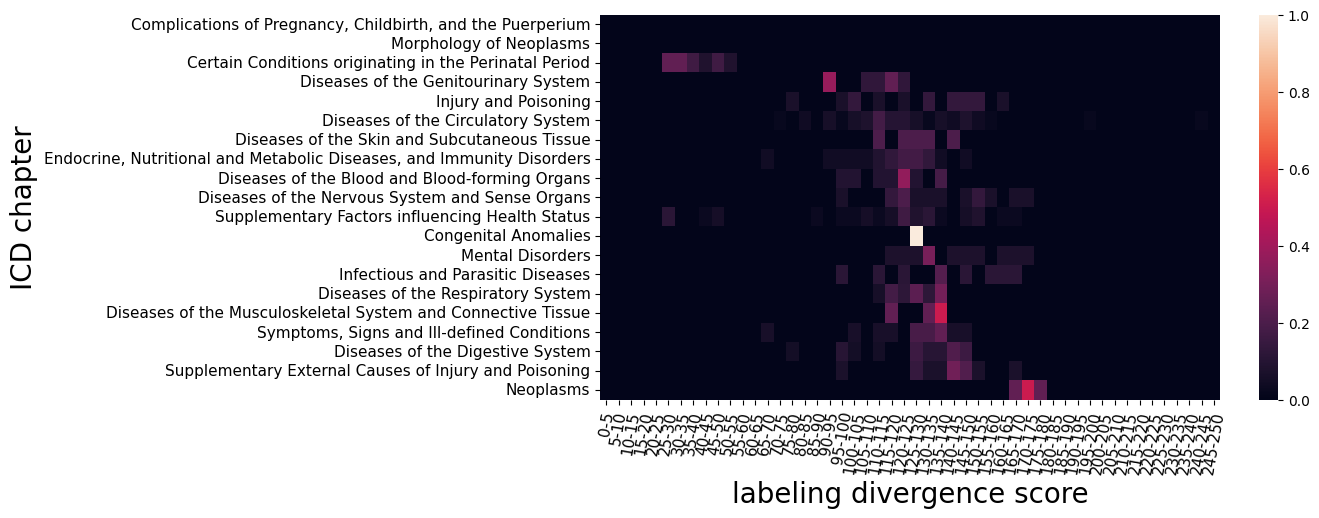

In [9]:
# sort heatmap_df by argmax of the label divergence score

plt.figure(figsize=[10,5])
fig_path = os.path.join(output_dir, "exp3_heatmap.pdf")
sns.heatmap(heatmap_df.pivot('chapter_rank', 'div_score_bin', 'density'), xticklabels=xticklabels, yticklabels=yticklabels)
plt.xlabel("labeling divergence score", fontsize=20)
plt.ylabel("ICD chapter", fontsize=20)
plt.xticks(fontsize=11, rotation=80)
plt.yticks(fontsize=11)
plt.savefig(fig_path, bbox_inches = 'tight')
plt.show()

In [10]:
""" 
Make the heatmap prettier
"""

# filter out "Diseases of the Circulatory System", 

# chapter: 1-20
# div_score_bin: 1-10
chapter_num = 20

div_score_bin_width = 5
div_score_max = 200
div_score_min = 25
div_score_bin_num = int((div_score_max-div_score_min)/div_score_bin_width)


def determine_div_score_bin(div_score):
    return floor((div_score-div_score_min)/div_score_bin_width)+1

heatmap_dict = {}
for chapter_index in range(1, chapter_num+1):
    if chapter_index == 14 or chapter_index == 11 or chapter_index == 20:
        continue
    heatmap_dict[chapter_index] = {}
    for div_index in range(1, div_score_bin_num+1):
        heatmap_dict[chapter_index][div_index] = 0

for index, row in label_code_df.iterrows():
    chapter_index = decide_ICD_chapter(index)[0]
    if chapter_index == 14 or chapter_index == 11 or chapter_index == 20:
        continue
    if row['div_score'] > div_score_max or row['div_score'] < div_score_min:
        continue
    div_index = determine_div_score_bin(row['div_score'])
    
    heatmap_dict[chapter_index][div_index] += 1
# print(heatmap_dict)

# normalize count to be rate, and compute the max rate bin
max_bin_ids = []
for chapter_index, chapter_item in heatmap_dict.items():
    # print(list(chapter_item.values))
    total_count = sum(chapter_item.values())
    # print(chapter_item.values())
    max_bin_id = np.argmax(list(chapter_item.values()))+1
    if total_count == 0:
        max_bin_ids.append(0)
        continue
    max_bin_ids.append(max_bin_id)
    for div_index in chapter_item:
        heatmap_dict[chapter_index][div_index] /= total_count
# print(heatmap_dict)

chapter_ranks = ss.rankdata(max_bin_ids, method='ordinal')
# print("chapter ranks is:", chapter_ranks)


heatmap_vec = []
for chapter_index, chapter_item in heatmap_dict.items():
    for div_index, count in chapter_item.items():
        if chapter_index < 11:
            heatmap_vec.append([chapter_ranks[chapter_index-1], div_index, count])
        elif chapter_index < 14:
            heatmap_vec.append([chapter_ranks[chapter_index-2], div_index, count])
        elif chapter_index < 20:
            heatmap_vec.append([chapter_ranks[chapter_index-3], div_index, count])
# print("heatmap_vec is:", heatmap_vec)

labels = ["Infectious and Parasitic Diseases", 
               "Neoplasms", 
               "Endocrine, Nutritional and Metabolic Diseases, and Immunity Disorders", \
                "Diseases of the Blood and Blood-forming Organs", \
                "Mental Disorders", \
                "Diseases of the Nervous System and Sense Organs", \
                "Diseases of the Circulatory System", 
                "Diseases of the Respiratory System", 
                "Diseases of the Digestive System", \
                "Diseases of the Genitourinary System", 
                # "Complications of Pregnancy, Childbirth, and the Puerperium", 
                "Diseases of the Skin and Subcutaneous Tissue",\
                "Diseases of the Musculoskeletal System and Connective Tissue", 
                # "Congenital Anomalies", 
                "Certain Conditions originating in the Perinatal Period", \
                "Symptoms, Signs and Ill-defined Conditions", 
                "Injury and Poisoning",
                "Supplementary External Causes of Injury and Poisoning",
                "Supplementary Factors influencing Health Status",
                # "Morphology of Neoplasms"
                ]

yticklabels = [""]*len(chapter_ranks)
# print(chapter_ranks)
for i in range(len(chapter_ranks)):
    yticklabels[chapter_ranks[i]-1] = labels[i]

# print(yticklabels)
    
xticklabels = []
for bin_index in range(div_score_bin_num):
    xticklabels.append(f'{int(bin_index*div_score_bin_width)+div_score_min}-{int((bin_index+1)*div_score_bin_width)+div_score_min}')
heatmap_df = pd.DataFrame(heatmap_vec, columns=['chapter', 'div_score_bin', 'density'])
heatmap_df[heatmap_df["chapter"]==3]
# print(yticklabels)



,chapter,div_score_bin,density
490,3,1,0.000000
491,3,2,0.000000
492,3,3,0.000000
493,3,4,0.000000
494,3,5,0.000000
495,3,6,0.000000
496,3,7,0.000000
497,3,8,0.000000
498,3,9,0.000000
499,3,10,0.000000


/tmp/ipykernel_2599998/292784178.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  ax = sns.heatmap(heatmap_df.pivot('chapter', 'div_score_bin', 'density'), xticklabels=xticklabels, yticklabels=yticklabels, cmap="Blues")


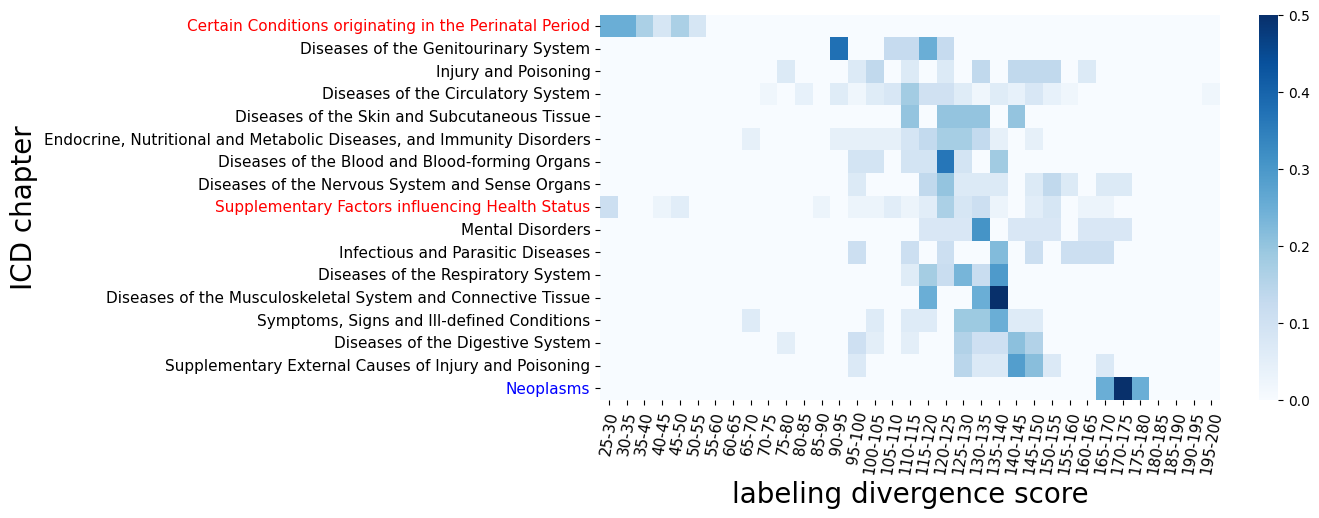

In [11]:
# sort heatmap_df by argmax of the label divergence score

plt.figure(figsize=[10,5])
fig_path = os.path.join(output_dir, "exp3_heatmap_subset.pdf")
ax = sns.heatmap(heatmap_df.pivot('chapter', 'div_score_bin', 'density'), xticklabels=xticklabels, yticklabels=yticklabels, cmap="Blues")
plt.xlabel("labeling divergence score", fontsize=20)
plt.ylabel("ICD chapter", fontsize=20)
plt.xticks(fontsize=11, rotation=80)
plt.yticks(fontsize=11)
for i, tick_label in enumerate(ax.axes.get_yticklabels()):
    # print(tick_label)
    if i == 0 or i == 8:
        tick_label.set_color("red")
    if i == 16:
        tick_label.set_color("blue")

plt.savefig(fig_path, bbox_inches = 'tight')
plt.show()

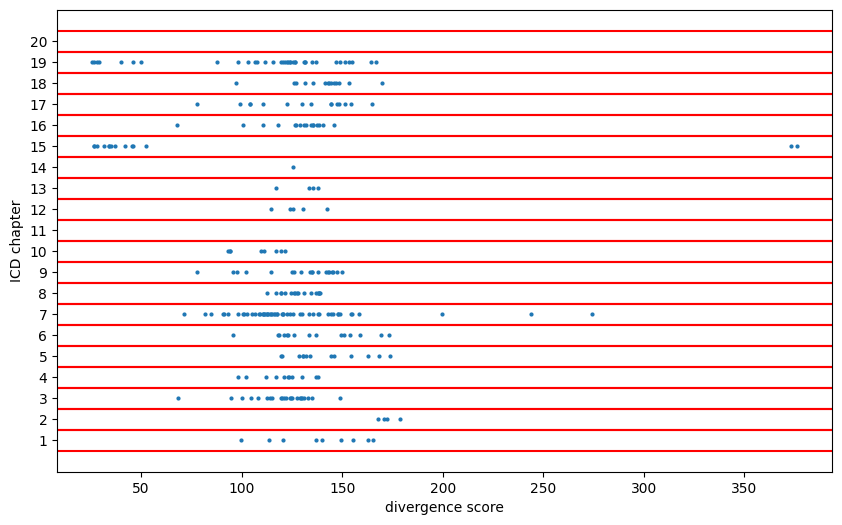

In [18]:
plt.figure(figsize=[10, 6])
plt.scatter(list(label_code_df['div_score']), chapters, s=4)
chapter_num = 20
plt.yticks(range(1, chapter_num+1))
for i in range(chapter_num):
    plt.axhline(i+0.5, color='red')
    plt.axhline(i+1.5, color='red')
plt.ylabel("ICD chapter")
plt.xlabel("divergence score")
# plt.title("ICD chapter vs transferability score rank")
plt.savefig("../../outputs/mimic/exp3_chapter.png")
plt.show()


ICD codes dense at lower rank: 4 (Diseases of the Blood and Blood-forming Organs), 8 (Diseases of the Respiratory System), 15 (Certain Conditions originating in the Perinatal Period)

ICD codes dense at higher rank: 2 (Neoplasms), 9 (Diseases of the Digestive System), 17 (Injury and Poisoning), 18 (Supplementary Classification of External Causes of Injury and Poisoning)

Question: What does the transferability score suggest? Is transferability score low a good thing?

- the classification task: predicts the presence of one code given other codes, the dependence between one code and the rest modelled by the logistic regression

- representations between two domains with the target code being the response can be more easily transfered/aligned

- application: predicting missing data for the test set.